spatial autocorrelation

In [4]:
access = '/mica/mica1/03_projects/yigu/'

import os
if os.uname()[1] == 'Yigus-MacBook-Air.local':
    access = '/Users/yiguz/remoteaccess/'

In [5]:
import libpysal
import nibabel as nb
import numpy as np

surfdir = access + '/surfaces/'

src = {'L':surfdir + 'fsLR-32k/surf/fsLR-32k.L.surf.gii', 'R': surfdir + 'fsLR-32k/surf/fsLR-32k.L.surf.gii'}

# read surface information to construct mesh through pymesh
f32k = {'L': nb.load(src['L']), 'R': nb.load(src['R'])}

# construct spatial weights from adjacency dictionary
neighbours = np.load(surfdir + 'fsLR-32k/surf/fsLR-32k_L_neighbours.npy', allow_pickle=True)
neighbours = neighbours.item()

W = libpysal.weights.W(neighbours) # binary queen contiguity

In [6]:
# fetch maps
import neuromaps.datasets
#print(neuromaps.datasets.available_annotations())
fc1 = neuromaps.datasets.fetch_annotation(source = 'margulies2016', desc='fcgradient01')
myelin = neuromaps.datasets.fetch_annotation(source = 'hcps1200', desc = 'myelinmap')

sig1 = nb.load(fc1[0]); sig1 = sig1.darrays[0].data
sig2 = nb.load(myelin[0]); sig2 = sig2.darrays[0].data

global autocorrelation and spatial lag

In [7]:
# spatial lag
y1 = np.asarray(sig1,dtype='float64')
y2 = np.asarray(sig2,dtype='float64')
y_slag1 = libpysal.weights.lag_spatial(W, y1)
y_slag2 = libpysal.weights.lag_spatial(W, y2)

# Global Spatial Autocorrelation
import esda
I1 = esda.Moran(y=y1, w=W, transformation='r', permutations=1000)
I2 = esda.Moran(y=y2, w=W, transformation='r', permutations=1000)

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_25926/3899838423.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p = plot_surf(src['L'], y1, cmap = 'inferno', colorbar = True, cbar_tick_format='%1.2f'); p.show()


Text(0.5, 0.98, 'fcgradient01')

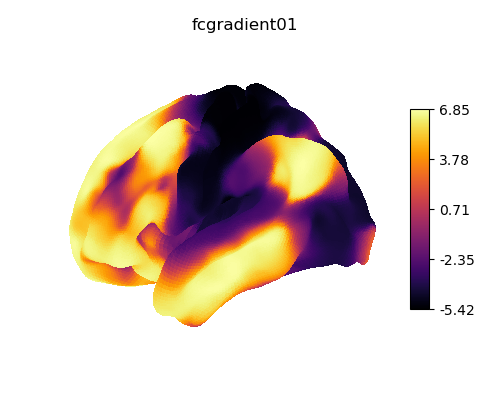

In [8]:
from nilearn.plotting import plot_surf

p = plot_surf(src['L'], y1, cmap = 'inferno', colorbar = True, cbar_tick_format='%1.2f')
p.suptitle('fcgradient01')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_25926/3543548930.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p = plot_surf(src['L'], y2, cmap = 'cividis', colorbar = True, cbar_tick_format='%1.2f'); p.show()
/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_25926/3543548930.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


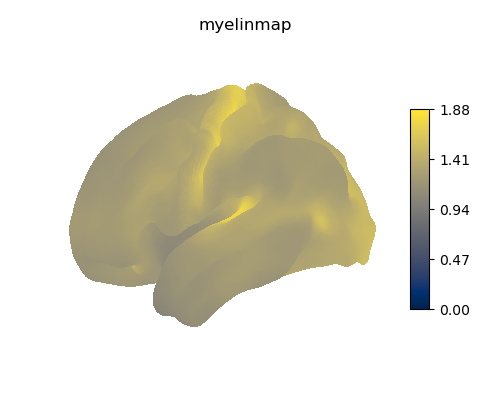

In [10]:
p = plot_surf(src['L'], y2, cmap = 'cividis', colorbar = True, cbar_tick_format='%1.2f')
p.suptitle('myelinmap')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_24173/3572883411.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


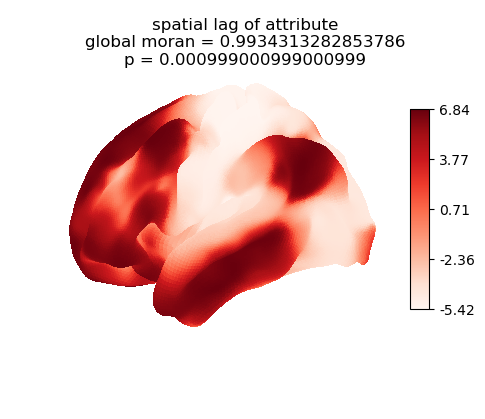

In [29]:
p = plot_surf(src['L'], y_slag, colorbar=True, cmap = 'Reds', cbar_tick_format='%1.2f')
p.suptitle('spatial lag of attribute\nglobal moran = ' + str(I.I) + '\np = ' + str(I.p_sim))
p.show()

Text(0.5, 0, "Moran's I")

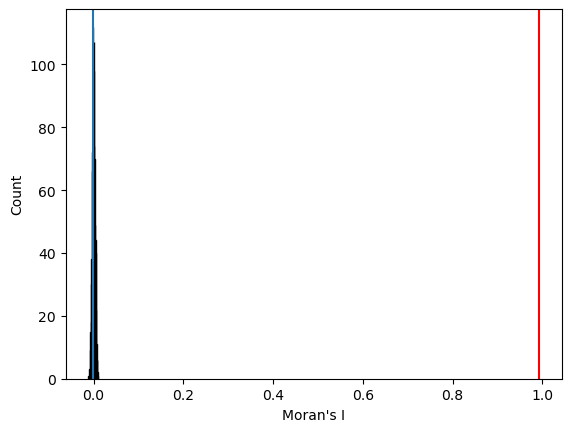

In [30]:
# null hypothesis = total spatial randomness

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(I.sim)
plt.axvline(I.I, color='r')
plt.axvline(I.EI)
plt.xlabel("Moran's I")

moran scatter plot for "spatial clustering"

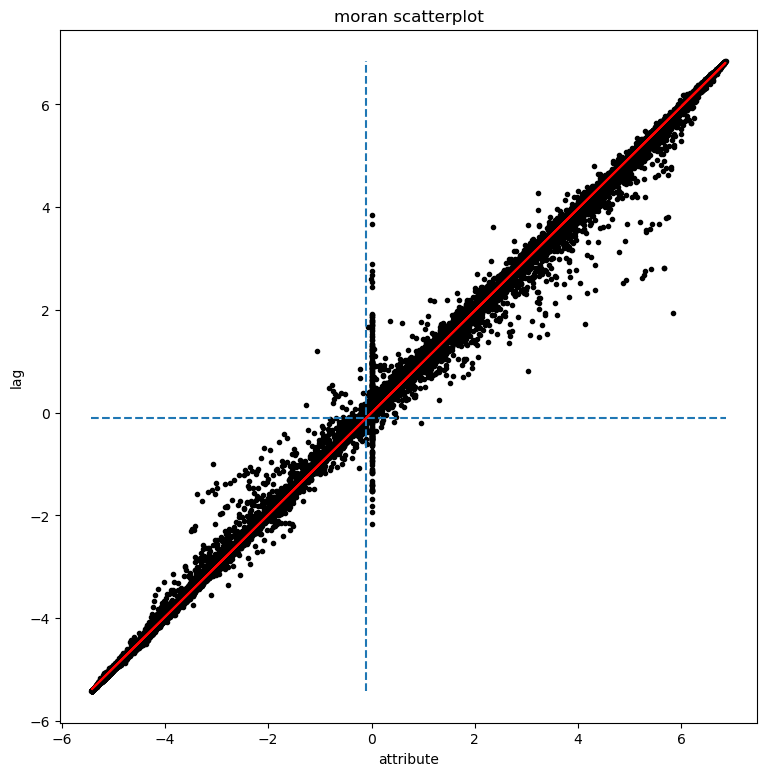

In [31]:
#plt.scatter(x=y, y=y_slag, color='k')
#plt.ylabel('lag'); plt.xlabel('attribute')

b, a = np.polyfit(y, y_slag, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(y, y_slag, '.', color = 'k')

# dashed vert at mean
plt.vlines(y.mean(), y_slag.min(), y_slag.max(), linestyle='--')
# dashed horizontal at mean of lagged attribute
plt.hlines(y_slag.mean(), y.min(), y.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(y, a + b*y, 'r')
plt.title('moran scatterplot')
plt.ylabel('lag')
plt.xlabel('attribute')
plt.show()

# ???? map has been artifically smoothed
# else why would you have 4 regimes of global autocorrelation?

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_24173/1337504086.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


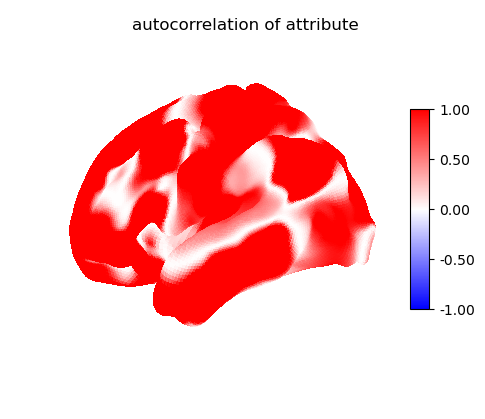

In [32]:
# local moran
local_I = esda.Moran_Local(y, W)
p = plot_surf(src['L'], local_I.Is, colorbar=True, cmap = 'bwr', vmin = -1, vmax = 1, cbar_tick_format='%1.2f')
p.suptitle('autocorrelation of attribute')
p.show()

# looks right, queen contiguity weighting similar to distance matrix for meylin but pulls out stronger autocorrelation for gradient 1

In [33]:
# quadrants !
# 1 - HH
# 2 - LH
# 3 - LL
# 4 - HL

#local_I.q
(local_I.p_sim < 0.05).sum()

20942

In [34]:
sig = local_I.p_sim < 0.05
hotspot = sig * local_I.q==1
coldspot = sig * local_I.q==3
doughnut = sig * local_I.q==2
diamond = sig * local_I.q==4

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_24173/541646505.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


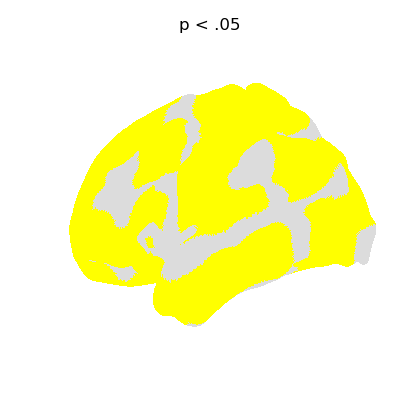

In [35]:
import matplotlib.colors

significant = matplotlib.colors.ListedColormap(['gainsboro', 'yellow'])

p = plot_surf(src['L'], sig, cmap = significant)
p.suptitle('p < .05')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_24173/1764794020.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


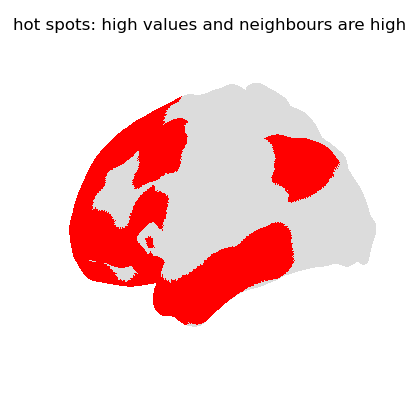

In [62]:
hot = matplotlib.colors.ListedColormap(['gainsboro', 'r'])

p = plot_surf(src['L'], hotspot, cmap = hot)
p.suptitle('hot spots: high values and neighbours are high')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_24173/3741722968.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


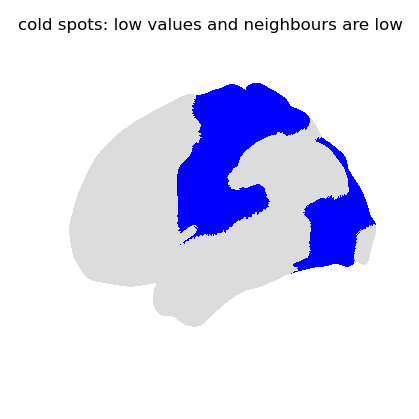

In [63]:
cold = matplotlib.colors.ListedColormap(['gainsboro', 'b'])

p = plot_surf(src['L'], coldspot, cmap = cold)
p.suptitle('cold spots: low values and neighbours are low')
p.show()

/Users/yiguz/anaconda3/lib/python3.11/site-packages/nilearn/plotting/surf_plotting.py:512: RuntimeWarning: invalid value encountered in divide
  data_copy /= (vmax - vmin)
/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_24173/1467171688.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


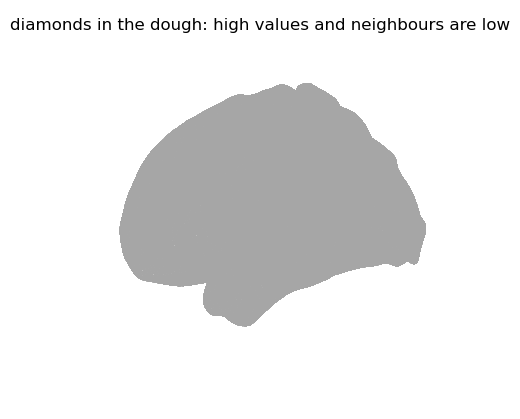

In [64]:
pink = matplotlib.colors.ListedColormap(['gainsboro', 'hotpink'])

p = plot_surf(src['L'], diamond, cmap = pink)
p.suptitle('diamonds in the dough: high values and neighbours are low')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_24173/1889791069.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


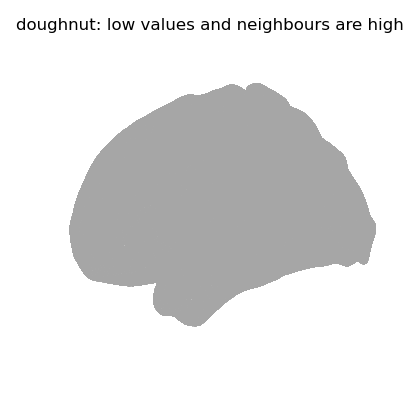

In [65]:
cyan = matplotlib.colors.ListedColormap(['gainsboro', 'cyan'])

p = plot_surf(src['L'], doughnut, cmap = cyan)
p.suptitle('doughnut: low values and neighbours are high')
p.show()